# Conv Architecture Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [4]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-conv-fix-params-and-seed',))]

In [5]:
len(experiment_rows)

72

In [6]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_holistic_only':
        arch = 'Holistic Only'
    else:
        arch = 'MP-CNN'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [7]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [8]:
trecqa.head(8)

,arch,dataset,metric_name,metric_val,seed,split
0,MP-CNN,trecqa,MAP,0.8088,524729,dev
1,MP-CNN,trecqa,MRR,0.8582,524729,dev
2,MP-CNN,trecqa,MAP,0.7823,524729,test
3,MP-CNN,trecqa,MRR,0.8279,524729,test
4,Holistic Only,trecqa,MAP,0.7931,524729,dev
5,Holistic Only,trecqa,MRR,0.8475,524729,dev
6,Holistic Only,trecqa,MAP,0.7961,524729,test
7,Holistic Only,trecqa,MRR,0.8468,524729,test


In [9]:
archs = ['MP-CNN', 'Holistic Only']
def compare_change_to_baseline(df, metric):
    changes = {'MP-CNN': 'baseline'}
    config_ids = df['seed'].unique()
    for arch in ('Holistic Only', ):
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'MP-CNN')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with holistic-only baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with holistic-only baseline: {np.mean(diffs):.4f}')
        diff = np.median(diffs)
        changes[arch] = f'+{diff:.4f}' if diff > 0 else f'{diff:.4f}'
    
    return changes

## TrecQA

In [10]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [11]:
trec_map_intervals = {}
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.7121, 0.7920)
Holistic Only: (0.7752, 0.7859)


In [12]:
trec_mrr_intervals = {}
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.7499, 0.8366)
Holistic Only: (0.8187, 0.8380)


In [13]:
trec_map_delta = compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Holistic Only
Median of MAP change compared with holistic-only baseline: 0.0056
Mean of MAP change compared with holistic-only baseline: 0.0285


In [14]:
trec_mrr_delta = compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Holistic Only
Median of MRR change compared with holistic-only baseline: 0.0102
Mean of MRR change compared with holistic-only baseline: 0.0351


## WikiQA

In [15]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [16]:
wikiqa_map_intervals = {}
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.5535, 0.7044)
Holistic Only: (0.5844, 0.6987)


In [17]:
wikiqa_mrr_intervals = {}
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.5611, 0.7180)
Holistic Only: (0.5931, 0.7120)


In [18]:
wikiqa_map_delta = compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Holistic Only
Median of MAP change compared with holistic-only baseline: 0.0052
Mean of MAP change compared with holistic-only baseline: 0.0126


In [19]:
wikiqa_mrr_delta = compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Holistic Only
Median of MRR change compared with holistic-only baseline: 0.0066
Mean of MRR change compared with holistic-only baseline: 0.0130


## SICK

In [20]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [21]:
sick_pearson_intervals = {}
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_pearson_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.8634, 0.8714)
Holistic Only: (0.8618, 0.8697)


In [22]:
sick_spearman_intervals = {}
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_spearman_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.7972, 0.8061)
Holistic Only: (0.7948, 0.8041)


In [23]:
sick_pearson_delta = compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Holistic Only
Median of pearson change compared with holistic-only baseline: -0.0013
Mean of pearson change compared with holistic-only baseline: -0.0017


In [24]:
sick_spearman_delta = compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Holistic Only
Median of spearman change compared with holistic-only baseline: -0.0022
Mean of spearman change compared with holistic-only baseline: -0.0022


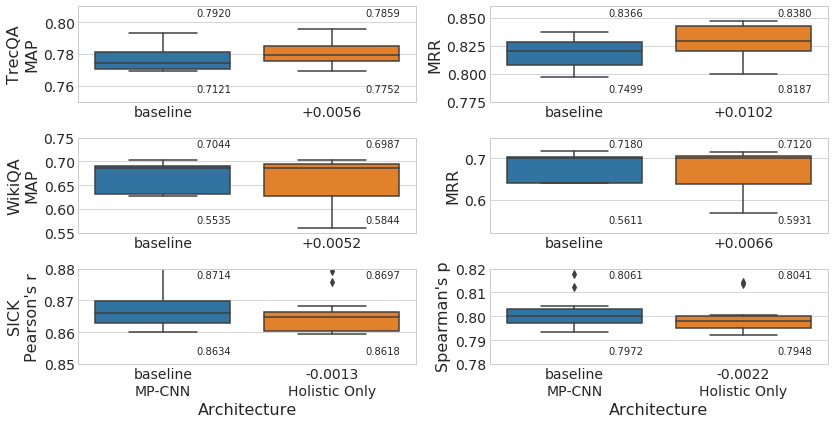

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 6)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.boxplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('TrecQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.75, 0.81))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([trec_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_map_intervals[a][1])

ax = plt.subplot(322)
sns.boxplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.775, 0.86))
ax.xaxis.set_ticklabels([trec_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_mrr_intervals[a][1])

ax = plt.subplot(323)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('WikiQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.55, 0.75))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][1])

ax = plt.subplot(324)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.52, 0.75))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][1])

ax = plt.subplot(325)
sns.boxplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("SICK\nPearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.85, 0.88))
ax.xaxis.set_ticklabels([sick_pearson_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_pearson_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_pearson_intervals[a][1])

ax = plt.subplot(326)
sns.boxplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.78, 0.82))
ax.xaxis.set_ticklabels([sick_spearman_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_spearman_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_spearman_intervals[a][1])
plt.tight_layout()
# plt.subplots_adjust(top=0.8, hspace=0.2)
plt.savefig('conv_arch_violin.pdf')